In [31]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# replace tqdm imported by any other module with tqdm.notebook
import sys
import tqdm
from tqdm.notebook import tqdm
sys.modules["tqdm"].tqdm = tqdm
sys.modules["tqdm.tqdm"] = tqdm
import ipywidgets as widgets # check if this is installed to make normal tqdm work inside the notebook

import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, VGG16

from art.estimators.classification import KerasClassifier

from art.attacks.evasion import SpatialTransformation
from art.attacks.evasion import FastGradientMethod

from art.defences.trainer import AdversarialTrainer

# from art.utils import load_mnist
from art.utils import load_dataset

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
# sn.set() #this changes the style of all plots, and imshow shows up wrong
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import platform
import subprocess
import shutil
import load10_temp as ltemp

In [32]:
img_size = 32

render_util_folder = os.getcwd()
blender_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\blender-2.78c-windows64" 

dataset_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\greebles-generator-master\Greebles_3DS_10"
render_folder = os.path.join(os.getcwd(), "greebles_10") #reduced dataset of 10

# Delete folder
# if os.path.exists(render_folder) and os.path.isdir(render_folder):
#     shutil.rmtree(render_folder)
    
if not os.path.isdir(dataset_folder):
    raise OSError(2, 'No such directory', str(dataset_folder))
if not os.path.exists(os.path.join(render_util_folder, 'render.py')):
    raise OSError(2, 'render.py not found', str(render_util_folder))

render_script = os.path.join(render_util_folder, 'render.py')

# Find the correct version of blender depending on the OS
if (platform.system() == "Windows"):
    blender_exec = os.path.join(blender_folder, 'blender.exe')
else:
    blender_exec = os.path.join(blender_folder, 'blender')
    
if not os.path.exists(os.path.join(blender_folder, blender_exec)):
    raise OSError(2, 'Blender executable not found', str(blender_folder))

# If you want to split command automatically
# import shlex; shlex.split("/bin/prog -i data.txt -o \"more data.txt\"")
# https://janakiev.com/blog/python-shell-commands/


set_mode = 'specific_all'
set_type = 'specific_angle'
#####################################
# Generate training set
blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                    '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                    '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', '0', '-zr', '0'])

# Move training set to folder                    
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
ltemp.move_to_folder(source_folder, os.path.join(source_folder, "train"))

In [33]:
# Step 1: Get training set

(x_train, y_train) = ltemp.load_dataset_temp("train", source_folder)
x_train = np.array(x_train, dtype='float64')
y_train = np.array(y_train, dtype='float32')

print(x_train.shape)
print(y_train.shape)
y_train

(10, 32, 32, 1)
(10, 10)


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [34]:
# Put all the different angles in a dictionary to access individually later
all_test = {}

test_set_gen_params = [-90, 90, 1]
test_set_name = "greebles10_test_{}_{}_{}.npy".format(
                test_set_gen_params[0], test_set_gen_params[1], test_set_gen_params[2])

test_set_path = os.path.join(source_folder, test_set_name)

if not (os.path.isfile(test_set_path)):
    # Generate test set
    for z in range(test_set_gen_params[0], test_set_gen_params[1] + 1, test_set_gen_params[2]):

        blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                            '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                            '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', '0', '-zr', str(z)])

        # Move training set to folder                    
        source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
        ltemp.move_to_folder(source_folder, os.path.join(source_folder, "test"))

        print(z, end=", ")
        (x_test, y_test) = ltemp.load_dataset_temp("test", source_folder)
        x_test = np.array(x_test, dtype='float64')
        y_test = np.array(y_test, dtype='float32')

        all_test[str(z)] = (x_test, y_test)
    
    # Save the concatenated set after loop
    np.save(test_set_path, all_test)


all_test = np.load(test_set_path, allow_pickle=True).item()
print("\n", all_test["90"][0].shape)


 (10, 32, 32, 1)


In [35]:
(x_test, y_test) = np.copy(all_test['90'][0]), np.copy(all_test['90'][1])
# IMPORTANT NOTE: The test set is not being normalized here, only training

# Normalize images, try scaling with the stdev. subtract mean and mult by a factor. or just leave them as is.
# x_train *= (1.0/x_train.max())
# x_test *= (1.0/x_test.max())

x_train *= (1.0/255)
x_test *= (1.0/255)

print(np.max(x_train))
print(np.min(x_train))
print(np.max(x_test))
print(np.min(x_test))

class_names = ltemp.get_class_names()
print(class_names)
# print(class_names['train'] == class_names['test'])
print("Classes for confusion matrix")
for idx, c in enumerate(class_names['train']):
    print("{}: {}".format(idx, c))

0.6196078431372549
0.22745098039215686
0.6274509803921569
0.2196078431372549
{'train': array(['f-1', 'f-2', 'f-3', 'f-4', 'f-5', 'm-1', 'm-2', 'm-3', 'm-4',
       'm-5'], dtype='<U3')}
Classes for confusion matrix
0: f-1
1: f-2
2: f-3
3: f-4
4: f-5
5: m-1
6: m-2
7: m-3
8: m-4
9: m-5


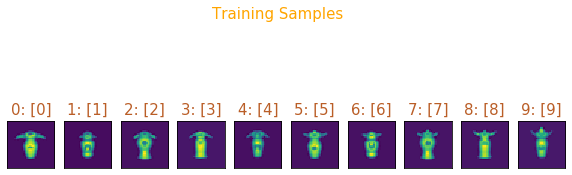

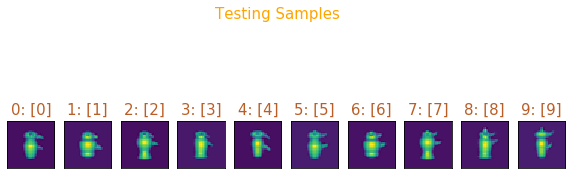

In [36]:
# Step 1.1: Visualize training set and labels
fig, axes = plt.subplots(1,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i][:,:,0], interpolation='nearest')
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(1,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

In [37]:
# Step 2: Create the model
keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(32, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=["accuracy"])
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.1), metrics=["accuracy"])
#############################
# model.add(ResNet50(input_shape=(img_size,img_size,1),include_top=False, pooling='avg', weights=None))
# model.add(Dense(10, activation="softmax"))

# model.add(VGG16(input_shape=(img_size,img_size,1),include_top=True, pooling='max', weights=None, classes=10))

# model.compile(
#     loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
# )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 4)         104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 10)        1010      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total para

In [38]:
# Step 3: Create the ART classifier
min_pixel_value = 0.0
max_pixel_value = 1.0
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

In [39]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=10, nb_epochs=500)

all_acc = {}

Epoch 1/500
1/1 [==============================] - 0s 436ms/step - loss: 2.3091 - acc: 0.2000
Epoch 2/500
1/1 [==============================] - 0s 8ms/step - loss: 2.3042 - acc: 0.0000e+00
Epoch 3/500
1/1 [==============================] - 0s 8ms/step - loss: 2.3054 - acc: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 9ms/step - loss: 2.3142 - acc: 0.1000
Epoch 5/500
1/1 [==============================] - 0s 10ms/step - loss: 2.3017 - acc: 0.0000e+00
Epoch 6/500
1/1 [==============================] - 0s 11ms/step - loss: 2.2958 - acc: 0.1000
Epoch 7/500
1/1 [==============================] - 0s 13ms/step - loss: 2.2950 - acc: 0.0000e+00
Epoch 8/500
1/1 [==============================] - 0s 9ms/step - loss: 2.3044 - acc: 0.1000
Epoch 9/500
1/1 [==============================] - 0s 10ms/step - loss: 2.2673 - acc: 0.7000
Epoch 10/500
1/1 [==============================] - 0s 9ms/step - loss: 2.2735 - acc: 0.3000
Epoch 11/500
1/1 [==============================] - 0s 12

Epoch 89/500
1/1 [==============================] - 0s 6ms/step - loss: 2.1428 - acc: 0.4000
Epoch 90/500
1/1 [==============================] - 0s 7ms/step - loss: 2.0032 - acc: 0.3000
Epoch 91/500
1/1 [==============================] - 0s 6ms/step - loss: 1.9643 - acc: 0.4000
Epoch 92/500
1/1 [==============================] - 0s 8ms/step - loss: 2.1370 - acc: 0.1000
Epoch 93/500
1/1 [==============================] - 0s 6ms/step - loss: 1.9128 - acc: 0.5000
Epoch 94/500
1/1 [==============================] - 0s 7ms/step - loss: 2.1316 - acc: 0.4000
Epoch 95/500
1/1 [==============================] - 0s 8ms/step - loss: 2.1844 - acc: 0.3000
Epoch 96/500
1/1 [==============================] - 0s 7ms/step - loss: 2.2169 - acc: 0.3000
Epoch 97/500
1/1 [==============================] - 0s 6ms/step - loss: 1.9868 - acc: 0.4000
Epoch 98/500
1/1 [==============================] - 0s 8ms/step - loss: 2.1097 - acc: 0.5000
Epoch 99/500
1/1 [==============================] - 0s 7ms/step - loss

1/1 [==============================] - 0s 7ms/step - loss: 0.7872 - acc: 0.8000
Epoch 177/500
1/1 [==============================] - 0s 6ms/step - loss: 0.7822 - acc: 0.8000
Epoch 178/500
1/1 [==============================] - 0s 6ms/step - loss: 0.5991 - acc: 0.9000
Epoch 179/500
1/1 [==============================] - 0s 8ms/step - loss: 0.7175 - acc: 0.8000
Epoch 180/500
1/1 [==============================] - 0s 7ms/step - loss: 0.7770 - acc: 0.8000
Epoch 181/500
1/1 [==============================] - 0s 8ms/step - loss: 0.7438 - acc: 0.9000
Epoch 182/500
1/1 [==============================] - 0s 7ms/step - loss: 0.6144 - acc: 1.0000
Epoch 183/500
1/1 [==============================] - 0s 7ms/step - loss: 0.7892 - acc: 0.9000
Epoch 184/500
1/1 [==============================] - 0s 7ms/step - loss: 0.6661 - acc: 0.8000
Epoch 185/500
1/1 [==============================] - 0s 7ms/step - loss: 0.5955 - acc: 0.9000
Epoch 186/500
1/1 [==============================] - 0s 8ms/step - loss: 0

1/1 [==============================] - 0s 7ms/step - loss: 0.1645 - acc: 1.0000
Epoch 264/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1525 - acc: 1.0000
Epoch 265/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1582 - acc: 1.0000
Epoch 266/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1943 - acc: 1.0000
Epoch 267/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1159 - acc: 1.0000
Epoch 268/500
1/1 [==============================] - 0s 8ms/step - loss: 0.1212 - acc: 1.0000
Epoch 269/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1463 - acc: 1.0000
Epoch 270/500
1/1 [==============================] - 0s 10ms/step - loss: 0.1524 - acc: 1.0000
Epoch 271/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1590 - acc: 1.0000
Epoch 272/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1852 - acc: 1.0000
Epoch 273/500
1/1 [==============================] - 0s 7ms/step - loss: 

1/1 [==============================] - 0s 7ms/step - loss: 0.0428 - acc: 1.0000
Epoch 351/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0463 - acc: 1.0000
Epoch 352/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0226 - acc: 1.0000
Epoch 353/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0425 - acc: 1.0000
Epoch 354/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0425 - acc: 1.0000
Epoch 355/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0392 - acc: 1.0000
Epoch 356/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0222 - acc: 1.0000
Epoch 357/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0415 - acc: 1.0000
Epoch 358/500
1/1 [==============================] - 0s 9ms/step - loss: 0.0503 - acc: 1.0000
Epoch 359/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0272 - acc: 1.0000
Epoch 360/500
1/1 [==============================] - 0s 6ms/step - loss: 0

1/1 [==============================] - 0s 8ms/step - loss: 0.0237 - acc: 1.0000
Epoch 438/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0169 - acc: 1.0000
Epoch 439/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0192 - acc: 1.0000
Epoch 440/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0145 - acc: 1.0000
Epoch 441/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0135 - acc: 1.0000
Epoch 442/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0405 - acc: 1.0000
Epoch 443/500
1/1 [==============================] - 0s 8ms/step - loss: 0.0300 - acc: 1.0000
Epoch 444/500
1/1 [==============================] - 0s 6ms/step - loss: 0.0180 - acc: 1.0000
Epoch 445/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0179 - acc: 1.0000
Epoch 446/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0316 - acc: 1.0000
Epoch 447/500
1/1 [==============================] - 0s 7ms/step - loss: 0

Accuracy on benign test examples: 50.0%
[0 1 2 3 4 5 6 7 8 9] 10
[0 3 5 6 7] 5
Accuracy Score : 0.5
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           5       0.33      1.00      0.50         1
           6       0.50      1.00      0.67         1
           7       0.50      1.00      0.67         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.50        10
   macro avg       0.28      0.50      0.35        10
weighted avg       0.28      0.50      0.35        10



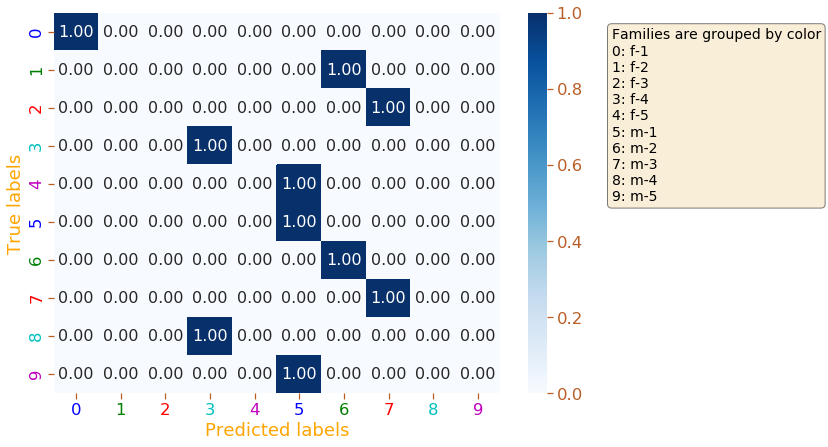

In [40]:
# Step 5: Evaluate the ART classifier on benign test examples
# predictions = classifier.predict(x_train)
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
all_acc['nat'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize, https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7))

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues

plt.xlabel('Predicted labels');
plt.ylabel('True labels');

LABEL_COLOR_MAP = {0: 'b',
                   1: 'g',
                   2: 'r',
                   3: 'c',
                   4: 'm',
                   5: 'orange',
                   6: 'k'
                   }

num_classes = len(class_names['train'])
ax = plt.gca()
for i in range(num_classes):
    c = LABEL_COLOR_MAP[i%(num_classes//2)]
    ax.get_xticklabels()[i].set_color(c)
    ax.get_yticklabels()[i].set_color(c)


textstr = '\n'.join((
    r'$\mu=%.2f$' % (2, ),
    r'$\mathrm{median}=%.2f$' % (5, ),
    r'$\sigma=%.2f$' % (1, )))

textstr = "Families are grouped by color\n" + '\n'.join("{}: {}".format(idx, c) for idx, c in enumerate(class_names['train']))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.90, 0.85, textstr, color='black', transform=plt.gcf().transFigure, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

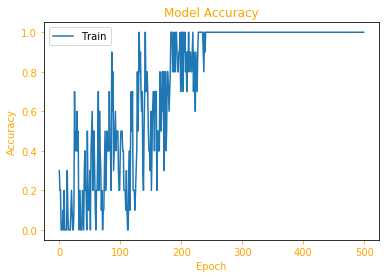

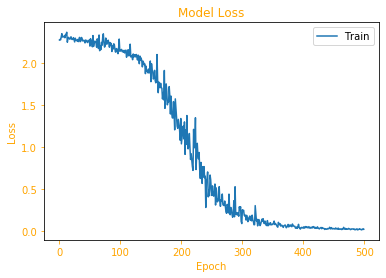

In [16]:
# Training graphs
plt.figure()
ax = plt.gca()
plt.plot(classifier._model.history.history['acc'])
plt.ylabel('Accuracy', color="orange")
plt.xlabel('Epoch', color="orange")
plt.legend(['Train'], loc='best')
plt.title('Model Accuracy', color="orange")
ax.tick_params(axis='x', colors="orange")
ax.tick_params(axis='y', colors="orange")

plt.figure()
ax = plt.gca()
plt.plot(classifier._model.history.history['loss'])
plt.ylabel('Loss', color="orange")
plt.xlabel('Epoch', color="orange")
plt.legend(['Train'], loc='best')
plt.title('Model Loss', color="orange")
ax.tick_params(axis='x', colors="orange")
ax.tick_params(axis='y', colors="orange")

plt.show()

In [17]:
all_acc = {}
for k in all_test.keys():
#     (x_test, y_test) = all_test[k]
    (x_test, y_test) = np.copy(all_test[k][0]), np.copy(all_test[k][1])
    # Normalize
    x_test *= (1.0/255)
    # Calculate accuracy
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    all_acc[k] = accuracy
    print("Accuracy on {} degrees: {}%".format(k, accuracy * 100))

Accuracy on -90 degrees: 40.0%
Accuracy on -89 degrees: 40.0%
Accuracy on -88 degrees: 40.0%
Accuracy on -87 degrees: 30.0%
Accuracy on -86 degrees: 30.0%
Accuracy on -85 degrees: 40.0%
Accuracy on -84 degrees: 40.0%
Accuracy on -83 degrees: 40.0%
Accuracy on -82 degrees: 40.0%
Accuracy on -81 degrees: 40.0%
Accuracy on -80 degrees: 40.0%
Accuracy on -79 degrees: 40.0%
Accuracy on -78 degrees: 40.0%
Accuracy on -77 degrees: 40.0%
Accuracy on -76 degrees: 40.0%
Accuracy on -75 degrees: 40.0%
Accuracy on -74 degrees: 50.0%
Accuracy on -73 degrees: 50.0%
Accuracy on -72 degrees: 50.0%
Accuracy on -71 degrees: 50.0%
Accuracy on -70 degrees: 50.0%
Accuracy on -69 degrees: 50.0%
Accuracy on -68 degrees: 50.0%
Accuracy on -67 degrees: 50.0%
Accuracy on -66 degrees: 60.0%
Accuracy on -65 degrees: 50.0%
Accuracy on -64 degrees: 50.0%
Accuracy on -63 degrees: 60.0%
Accuracy on -62 degrees: 60.0%
Accuracy on -61 degrees: 60.0%
Accuracy on -60 degrees: 60.0%
Accuracy on -59 degrees: 60.0%
Accuracy

In [18]:
for k in all_acc.keys():
#     print("{};{}".format(k, all_acc[k]))
    print("{}".format(all_acc[k]))

0.4
0.4
0.4
0.3
0.3
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.4
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.6
0.5
0.5
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.7
0.6
0.7
0.7
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.8
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.8
0.8
0.8
0.9
0.9
0.9
0.9
0.9
0.9
0.9
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9
0.9
0.9
0.9
0.9
0.9
0.8
0.9
0.8
0.9
0.9
0.8
0.7
0.7
0.7
0.7
0.7
0.6
0.6
0.7
0.6
0.7
0.6
0.7
0.7
0.7
0.8
0.6
0.7
0.6
0.7
0.8
0.8
0.8
0.8
1.0
1.0
0.9
1.0
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.8
0.9
0.8
0.8
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7


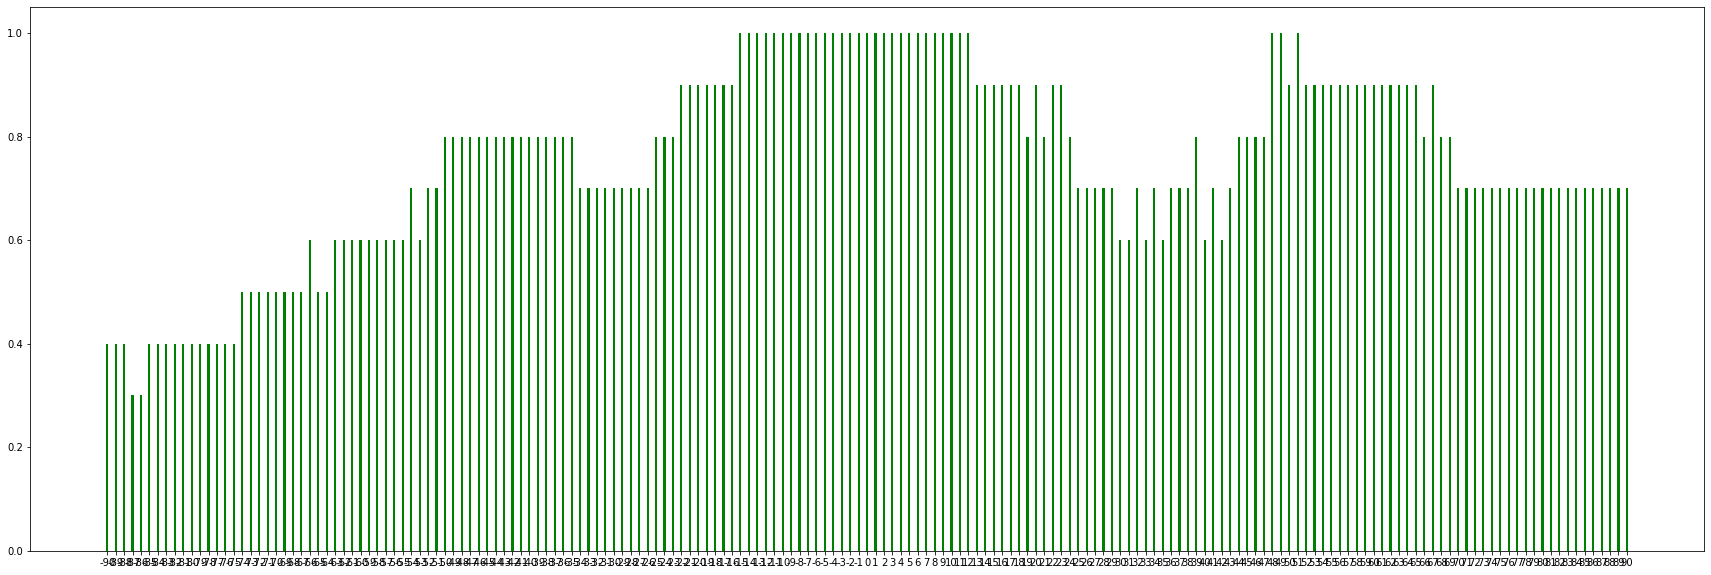

In [19]:
fig = plt.figure(figsize=(30,10))
plt.bar(all_acc.keys(), all_acc.values(), width = 0.25, color='g')
plt.show()

In [20]:
# Stop execution early
raise KeyboardInterrupt

KeyboardInterrupt: 

In [ ]:
# Step 6: Generate adversarial test examples

# Craft adversarial samples
print("Create adversarial attack")
attack = SpatialTransformation(classifier=classifier, max_translation=10.0, num_translations=1, max_rotation=30.0, num_rotations=1)
# attack = FastGradientMethod(classifier, eps=0.1)
print("Craft attack on training examples")
x_train_adv = attack.generate(x_train)
print("Craft attack test examples")
x_test_adv = attack.generate(x_test)

print(x_train_adv.shape)
print(x_test_adv.shape)

In [ ]:
# Step 6.1: Visualize adversarial samples
fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train_adv[i][:,:,0])
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test_adv[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Test Samples', fontsize=15, color='orange')

plt.show()

In [ ]:
# classifier.save("model.h5", path=".")

In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples before AT: {}%".format(accuracy * 100))
all_acc['adv_before_AT'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7), facecolor='None')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [ ]:
# Step 8: Create adversarial trainer and perform adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1.0)
adv_trainer.fit(x_train_adv, y_train, batch_size=64, nb_epochs=3)

In [ ]:
# Step 9: Evaluate new robustly trained classifier
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples after AT: {}%".format(accuracy * 100))
all_acc['adv_after_AT'] = accuracy * 100

print(all_acc)

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))

plt.figure(figsize=(10,7), facecolor='None')

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    hm = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [ ]:
dir(classifier)
# predictions[1]
# np.argmax(predictions, axis=1)
# classifier._loss
# classifier._loss_gradients
classifier.loss_gradient